# eCallisto Validation:

In [1]:
from validation.sources.validation import *
from validation import config as test_config

C:\Users\delbe\OneDrive\Desktop\eCallistoValidation\validation\sources\../..\radiospectra2\radiospectra\version.py:12: UserWarning: could not determine radiospectra package version; this indicates a broken installation
  warnings.warn(


* Die Verbindung mit der Datenbank.
* Auswahl alle daten von Validation_data Tabelle.
* Die alle Infos sind im config.py file.

In [ ]:
database = psycopg2.connect(host=test_config.DB_HOST,
                            user=test_config.DB_USER,
                            database=test_config.DB_DATABASE,
                            port=test_config.DB_PORT,
                            password=test_config.DB_PASSWORD)

#### Die alle Infos über den absolute Path und die Datenbanken.

In [ ]:
import os

PATH_PREFIX = '/data'
DATA_PATH = os.path.join(PATH_PREFIX, 'radio/2002-20yy_Callisto')

# database infos

DB_HOST = 'localhost'
DB_DATABASE = 'validation'
DB_USER = 'postgres'
DB_PASSWORD = 'ecallistohackorange'
DB_PORT = '5432' 

##### Hier ist ein sql query von der Datenbank, die Tabelle heisst: validation_data

In [ ]:
sql_query = "select * from validation_data"

###### dieser Funktion ruft  alle Daten aus der Datenbank zu bekommen auf.

In [ ]:
def get_all_instruments(database, sql_query):
    """
    Get the all instruments from the Database
    Parameters
    ----------
    database : a database 'Validation'.
    sql_query: a query of sql to execute the script.
    Returns
    -------
    index : index of the cursor from database.
    """

    sql_query_instruments = sql_query
    cursor = database.cursor(cursor_factory=psycopg2.extras.DictCursor)
    cursor.execute(sql_query_instruments)
    index = [row for row in cursor.fetchall()]

    return index


rows = get_all_instruments(database, sql_query)

##### dieser Funktion ist für update die berechneten snr und std in die Datenbank "Validation".

In [ ]:
"""
- Subtrahieren Sie den Hintergrund und berechnen Sie dann die Standardabweichung,
  den Mittelwert und die Signal-Rausch-Werte.
- Aktualisiert die berechneten Werte in die Datenbank (validation => validation_data)
"""

def update_all_values(rows):
    """
    Calculate the std and snr, then update them into the table in Database.
    Returns
    -------
    None
    """

    for row in rows:
        try:
            spec = CallistoSpectrogram.read(test_config.DATA_PATH + row[1])
            file_name = row[1].split("/")[4]


            spec2 = spec.subtract_bg("subtract_bg_sliding_window", window_width=800, affected_width=1,
                                     amount=0.05, change_points=True)

            data = np.absolute(spec2.data.flatten())
            std_data = np.std(data)
            mean_data = np.mean(data)
            snr_data = mean_data / std_data

            sql_update_query = f"""UPDATE validation_data SET std_values = {std_data}, snr_values = {snr_data} where id = {row[0]} """
            cursor.execute(sql_update_query)
            database.commit()

        except Exception as err:
            # print(f"The Error message is: {err} and the file name is {row[2]}")
            print(f"The Error message is: {err} and the file name is {file_name}")

        print(f"{file_name} is updated!")

#### Plot 4 Spalten mit (Original-Spektrogramm, Background subtracted ("constbacksub", "elimwrongchannels"), Gliding background subtracted, Histogramme.

In [ ]:
def get_plot(rows):
    """Plot 4 columns (original Spec,Background subtracted("constbacksub", "elimwrongchannels"),
        Gliding background subtracted, Histograms.

    :param rows: The rows from the database.
    :returns: 4 columns of the Input spec
    """
    for row in rows:
        try:
            spec = CallistoSpectrogram.read(test_config.DATA_PATH + row[1])
            fig1, axs1 = plt.subplots(1, 4, figsize=(27, 6))
            ax1 = spec.plot()
            ax1.title.set_text("Original Data")
            plt.close()

            # Second column, Constbacksub + elimwrongchannels
            spec2 = spec.subtract_bg("constbacksub", "elimwrongchannels")
            fig2 = plt.subplots(1, 4, figsize=(27, 6))
            ax2 = spec2.plot()
            ax2.title.set_text("Background subtracted")
            plt.close()

            # Third column, subtract_bg_sliding_window
            spec3 = spec.subtract_bg("subtract_bg_sliding_window", window_width=800, affected_width=1,
                                     amount=0.05, change_points=True)
            fig3 = plt.figure(figsize=(27, 6))
            ax3 = spec3.plot()
            ax3.title.set_text(
                "Gliding background subtracted (window=800)")
            plt.close()

            # Fourth column, Histograms
            fig4, ax4 = plt.subplots(figsize=(27, 6))

            # Fourth column, Histograms
            data_absolute3 = get_abs_data(spec2)
            data_absolute4 = get_abs_data(spec3)

            n, bins, patches = ax4.hist([data_absolute3, data_absolute4], histtype='step', bins=25, log = True,
                                        label=['Background subtracted', 'Gliding background subtracted'])

            # Calculate the standard deviation and signal-to-noise => rounded them to have 3 digits.
            std_data = round(np.std(data_absolute4), 3)
            snr_data = round(signal_to_noise(data_absolute4), 3)

            # Set title for the histograms and show the std/snr values.
            ax4.title.set_text(
                f"Histograms, std = {std_data}, snr = {snr_data}")
            plt.legend()
            plt.close()

            # Plot final plot by moving axes to the figure
            fig_target, (axA, axB, axC, axD) = plt.subplots(
                1, 4, figsize=(30, 9))
            plt.suptitle(fig1._suptitle.get_text())

            move_axes(fig_target, ax1, axA)
            move_axes(fig_target, ax2, axB)
            move_axes(fig_target, ax3, axC)
            move_axes(fig_target, ax4, axD)

            for ax in (ax1, ax2, ax3):
                ax.set_xlabel('Time[UT]')
                ax.set_ylabel('Frequency[MHz]')

            ax4.set_xlabel('Pixel values')
            ax4.set_ylabel('Number of pixels')
            plt.show()

        except Exception as err:

            print(f"The Error message is: {err} and the file name is {row[2]}")
            # print("The Error message is: %s and the file name is %s" % (err, row[2]))

#### Testing the snr and std values:

0 channels eliminated
Eliminating sharp jumps between channels ...
14 channels eliminated
Std for original Spec: 18.039881650783002
Mean for original Spec: 150.39272884283247
SNR for original Spec: 8.336680459115142


Std for subtracted Spec: 8.008
Mean for subtracted Spec: 6.352
SNR for subtracted Spec: 0.7932067932067933


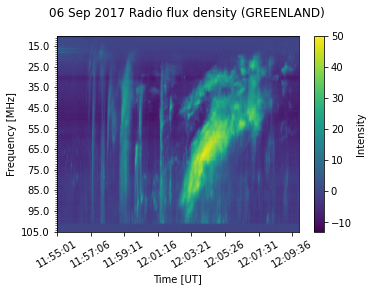

In [4]:
spec = CallistoSpectrogram.read("validation//fit_files//GREENLAND_20170906_115501_63.fit.gz")
# spec = CallistoSpectrogram.read("Spec_test//AUSTRIA-Krumbach_20190906_120000_10.fit.gz")

spec2 = spec.subtract_bg("constbacksub", "elimwrongchannels")

data = abs(spec.data.flatten())
data_bg = abs(spec2.data.flatten())

data_mean = data.mean()
data_std = np.std(data)

data_mean_bg = round(data_bg.mean(), 3)
data_std_bg = round(np.std(data_bg), 3)

print(f"Std for original Spec: {data_std}")
print(f"Mean for original Spec: {data_mean}")
print(f"SNR for original Spec: {data_mean / data_std}")

print("\n")

print(f"Std for subtracted Spec: {data_std_bg}")
print(f"Mean for subtracted Spec: {data_mean_bg}")
print(f"SNR for subtracted Spec: {data_mean_bg / data_std_bg}")
spec2.plot()
plt.show()

#### Testing the function interpolate2d:

0 channels eliminated
Eliminating sharp jumps between channels ...
14 channels eliminated
(3600,)
(200,)
(200, 3600)


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3600 / length of data axis 1                          
NAXIS2  =                  200 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy and
COMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.
COMMENT   Contact the NASA Science Office of Standards and Technology for the   
COMMENT   FITS Definition document #100 and other FITS information.             
DATE    = '2017-09-06'         / Time of observation                            
CONTENT = '2017/09/06  Radio flux density, e-CALLISTO (GREENLAND)' / Title of im
ORIGIN  = 'DK      '        

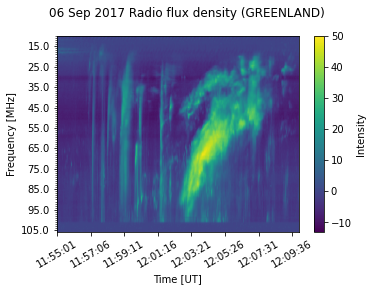

In [5]:
spec = CallistoSpectrogram.read("validation//fit_files//GREENLAND_20170906_115501_63.fit.gz")
spec_plot = interpolate2d(spec)
spec_plot.plot()

print(spec_plot.time_axis.shape)
print(spec_plot.freq_axis.shape)

print(spec_plot.data.shape)
spec_plot.header

#### requirements.txt :
* Enthält alle Module und Pakete, die für die Skripte importiert werden müssen

In [ ]:
astropy~=4.2.1
bs4~=0.0.1
connexion
flask
flask_compress
flask_cors
iso8601
numpy~=1.20.3
psycopg2~=2.9.1
Pillow~=8.2.0
ruptures~=1.1.3
scikit-image~=0.18.1
scipy~=1.7.1
sortedcontainers~=2.3.0
sunpy~=2.1.5
pandas~=1.3.2
matplotlib~=3.4.2
sqlalchemy~=1.4.23
setuptools~=56.2.0
beautifulsoup4~=4.9.3
PIL
pandas.io.sql
re
matplotlib.backends.backend_pdf
os
glob
sys
astropy.io.fits

scipy =>interpolate
copy => deepcopy